<a href="https://colab.research.google.com/github/nolauren/colabs/blob/main/DVT_Smithsonian_Postcards_Use_This_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Distant Viewing Toolkit: Smithsonian Postcard Demo**

For more information about the toolkit and the Distant Viewing Lab, please see our [GitHub page](https://github.com/distant-viewing/dvt).

# 1. Introduction

- How can we look at images through computers?
- How might they help us "see" and "view" in expected and unexpected ways?


This notebook uses the Distant Viewing Toolkit (DVT)to analyze real-photo postcards. Using computer vision, DVT facilitates the computational analysis of (moving) images. Specifically designed for the study of visual culture, the toolkit enacts the DV method. See our article in DSH at https://doi.org/10.1093/llc/fqz013 for more.


 A note about this notebook: This document displays a file known as a Jupyter notebook. In this case, it contains a mix of plain text (like this one!) and code in the open-source programing language Python. The notebook is being hosted on Google's Colab platform, which allows us to run the code for free on a third-party system without the need to install Python and its many dependencies on our local machine. If you are interested in using these methods further, however, it is possible to install all of this on your machine and run the code locally. See the [INSTALL.md](https://github.com/distant-viewing/dvt/blob/main/INSTALL.md) file for more information.

# 2. Setup

### 2.1 Installation

The Google Colab environment already has a running version of Python and several of the most common modules (third-party code that extends the basic language). We only need to install a few other pieces, such as Detectron2 and the Distant Viewing Toolkit. To do this, hover over the code block below and click on the run button that appears in the upper left corner of the block.

In [ ]:
!pip install -q pyyaml==5.1
!pip install -q keras tensorflow mtcnn
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install -q git+https://github.com/distant-viewing/dvt.git

     |████████████████████████████████| 274 kB 15.9 MB/s 
     |████████████████████████████████| 2.3 MB 15.0 MB/s 
     |████████████████████████████████| 6.9 MB 652 kB/s 
     |████████████████████████████████| 145 kB 15.2 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 130 kB 80.6 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 743 kB 86.0 MB/s 
     |████████████████████████████████| 749 kB 70.9 MB/s 
     |████████████████████████████████| 112 kB 70.3 MB/s 


It is possible that you may see one or two errors about extra dependencies. Our experience is that these can be ignored for the moment. However, before continuing, it is important that you first restart the Python runtime to properly finish the installation of the above components. To do this, click on the menu above and select the option **Runtime > Restart runtime**.

### 2.2 Load Data

Now that we have the Python modules installed, we next need to  download our image data. This can be done by running the following code block:

In [ ]:
!wget -q https://distantviewing.org/postcards.zip
!unzip -q postcards.zip

Once finished, you will have all of the images downloaded to the Colab. Let's load all of the metadata for the collection.

In [ ]:
import pandas

dt = pandas.read_csv("postcards/postcards.csv")
dt

filename  height  width              id   type
0     1986_3048_0642_back.jpg    1323   2000  1986.3048.0642   back
1    1986_3048_0642_front.jpg    1311   1999  1986.3048.0642  front
2     1986_3048_0645_back.jpg    2000   1333  1986.3048.0645   back
3    1986_3048_0645_front.jpg    1331   1999  1986.3048.0645  front
4     1986_3048_0647_back.jpg    1269   1999  1986.3048.0647   back
..                        ...     ...    ...             ...    ...
524     PG_78_38_35_front.jpg    1280   2000     PG.78.38.35  front
525      PG_78_38_36_back.jpg    1311   2000     PG.78.38.36   back
526     PG_78_38_36_front.jpg    1293   1999     PG.78.38.36  front
527      PG_78_38_37_back.jpg    1999   1329     PG.78.38.37   back
528     PG_78_38_37_front.jpg    1299   1999     PG.78.38.37  front

[529 rows x 5 columns]

### 2.3 Load Modules

As a final setup task, we need to load in all of the modules that we will use. Just run the following block to load these functions and classes. We will explain what each of these does during the demo.

In [ ]:
from dvt import (
    VideoFrameInput,
    VideoBatchInput,
    AverageAnnotator,
    InstanceAnnotator,
    LVISAnnotator,
    KeypointsAnnotator,
    PanopticAnnotator,
    FaceAnnotator,
    FaceDetectMtcnn,
    FaceEmbedVgg2,
    EmbedAnnotator,
    EmbedImageKerasResNet50,
    DiffAnnotator,
    CutAggregator,
    DVTOutput,
    imread
)
from google.colab.patches import cv2_imshow
import numpy as np

Note that you will ideally not see any output in the previous block, which means that everything loaded without a problem. If you did have an error, this is likely an indication that a more serious problem has occured.

# 3. Annotating One Image

### 3.1 Load the Image

Let's start by loading into Python one of the images that we downloaded. We can display the image in the notebook using the Colab function `cv_imshow`.

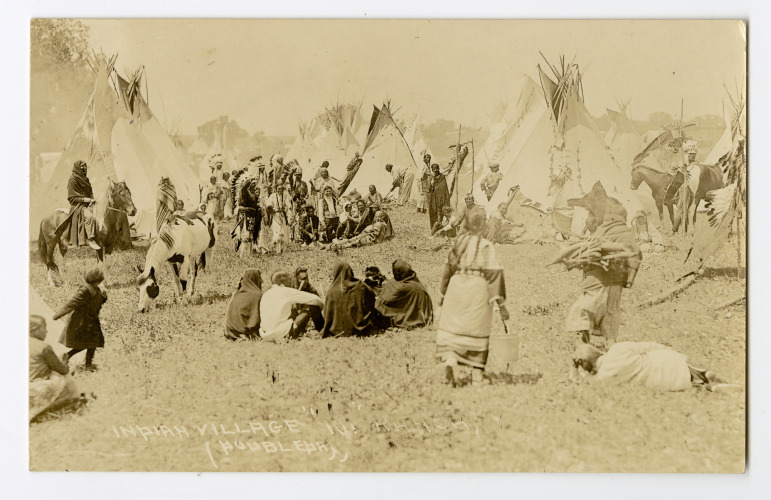

In [ ]:
img = imread("postcards/images/" + dt.filename[415])  #Change out the number with your choice!
cv2_imshow(img)

### 3.2 Simple Annotators

An *annotator* is what the DVT calls an object that takes an image or group of images as an input and returns structured information about the image as an output. As a starting point we will load in a relatively simply annotator that measures the average saturation (richness) and average value (brighness) of the image.

In [ ]:
anno = AverageAnnotator()

Using the `annotate` method, we see that the output is returned as a dictionary object with a single key named 'average'.

In [ ]:
annotation = anno.annotate(img)
annotation["average"]

saturation        val
0   54.020986  143.01883

A pandas DataFrame can be saved as a CSV file and then read back into any other statistical software, such as R, Excel, or Tableau.

### 3.3 Detecting and Identifying Faces

Now that we understand the basic structure of the toolkit, let's work through some more complex annotators. For example, we will use the `FaceAnnotator` to detect all of the faces in our example image. We pass both a detector (to find the faces) as well as an embedding (to identify the faces).

In [ ]:
anno = FaceAnnotator(detector=FaceDetectMtcnn(), embedding=FaceEmbedVgg2())
anno.annotate(img)['face']

94789632/94777312 [==============================] - 1s 0us/step


top  right  ...  confidence                                              embed
0  149    163  ...    0.800209  [0.06936554, 2.6128263, 0.0, 0.0, 7.478638, 0....

[1 rows x 6 columns]

The annotation includes detections of the image, which gives a bounding box for each face and a confidence score. The final column provides an *image embedding*. If we applied this to a larger collection, we could identify people across images/frames by associating embeddings that are very close to one another.

### 3.4 Image Embedding

Similar to a face embedding, we can also apply an embedding to the entire image. These are useful for doing visual search, building recommendor systems, and doing visualizations of a larger corpus. Here is an example embedding a single image:

In [ ]:
anno = EmbedAnnotator(embedding=EmbedImageKerasResNet50())
emdf = anno.annotate(img)['embed']
emdf

102981632/102967424 [==============================] - 1s 0us/step


embed
0  [0.25150558, 0.21041764, 0.28343922, 0.7432666...

The output gives an *embedding* as a sequence of 2048 (2^11) numbers.

In [ ]:
emdf.embed.values[0].shape

(2048,)

### 3.5 Instance Segmentation

Another annotator that exists in the toolkit conducts instance annotation. This annotators try to locate common objects and people in the frame of the image. Unlike the face detector, it tries to find entire people rather than only detecting faces. Here is what the structured output look like:

In [ ]:
anno = InstanceAnnotator()
anno.annotate(img)['instance']

model_final_f10217.pkl: 178MB [00:01, 90.6MB/s]                          
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding

index  height  width   class  ...          x0          y0          x1          y1
0      0     500    781  person  ...   67.477776  129.493561  210.247986  488.722687
1      1     500    781   clock  ...  311.051910  116.098709  341.888062  141.962128
2      2     500    781   chair  ...  184.088089  167.898865  310.809235  499.291382

[3 rows x 9 columns]

The annotator also provides a method called `visualize_last_predictions` to show what the entire region detected for each object looks like, which can be helpful for understanding the inner workings of the algorithm, what it detects well, and the mistakes it makes.

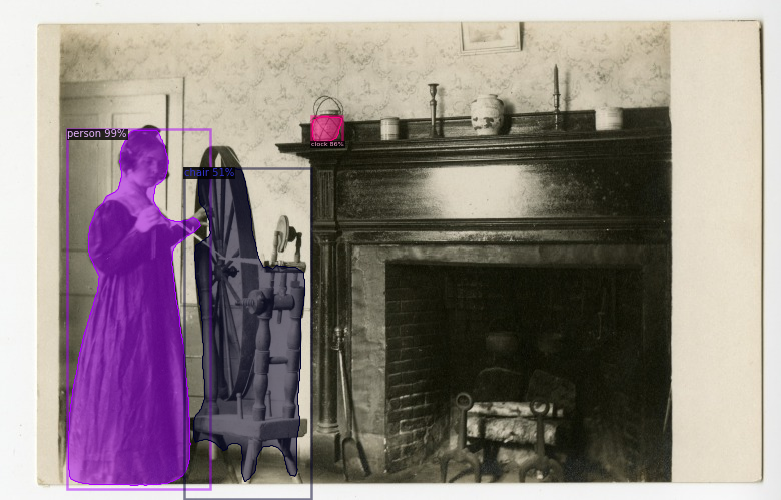

In [ ]:
out = anno.visualize_last_predictions(img)
cv2_imshow(out)

### 3.5 Panoptic Segmentation

Panoptic segmentation works similarly to image segmentation, but includes not just *things* (and people), but also *stuff*, such as the sky, grass, and other uncountable objects. Here we see the extra categories included in the output.

In [ ]:
anno = PanopticAnnotator()
anno.annotate(img)['panoptic']

model_final_c10459.pkl: 184MB [00:02, 87.5MB/s]                           


index  height  width     score  is_thing       class    area
0      0     500    781  0.996266      True      person   31883
1      1     500    781  0.763674      True        vase    1208
2      2     500    781  0.647425      True       chair   23460
3      3     500    781  0.584743      True       chair    8776
4      4     500    781  0.000000     False  door-stuff   11556
5      5     500    781  0.000000     False  wall-brick   24206
6      6     500    781  0.000000     False       floor    8253
7      7     500    781  0.000000     False        wall  228890

As with the image segmentation, we can look at the predictions to see how they correspond to our own viewing of the image.

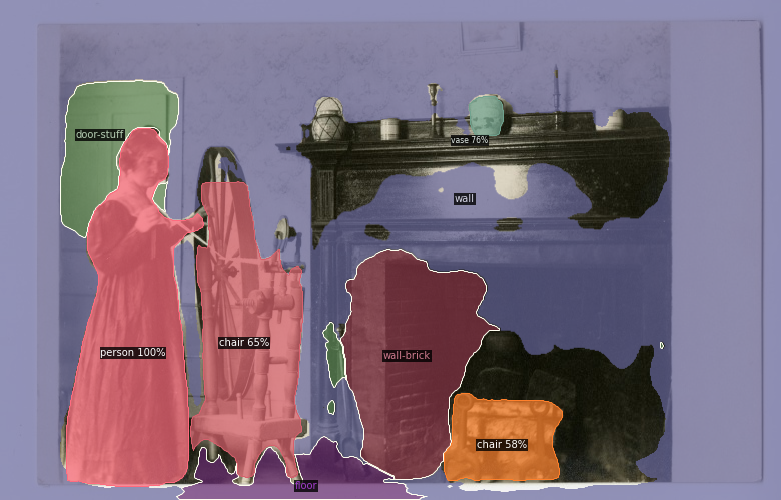

In [ ]:
out = anno.visualize_last_predictions(img)
cv2_imshow(out)

### 3.7 Keypoint Detection

Many image analysis tasks require understanding exactly where people are within
the frame of the image. We can get more information about the location of
people in the frame by using Keypoint detection, another included algorithm in
DVT. Here, we detect the keypoints (17 points associated
with the human body) of the people in our image. The x and y axis count starts from the top left.


In [ ]:
anno = KeypointsAnnotator()
anno.annotate(img)['keypoint']

model_final_a6e10b.pkl: 237MB [00:03, 73.4MB/s]                           


index          kpname           x           y     score
0       0            nose  155.749222  170.562469  0.805588
1       0        left_eye  160.119247  164.940979  1.098814
2       0       right_eye  149.506302  163.067154  0.852506
3       0        left_ear  164.489288  168.064041  0.273685
4       0       right_ear  130.777603  166.190201  0.673380
5       0   left_shoulder  149.506302  208.663757  0.237695
6       0  right_shoulder  113.921776  209.912994  0.276568
7       0      left_elbow  155.124924  248.638885  0.202369
8       0     right_elbow  108.927452  261.755707  0.396164
9       0      left_wrist  190.085175  224.279037  0.578974
10      0     right_wrist  136.396225  233.023605  0.523343
11      0        left_hip  154.500626  314.223053  0.150760
12      0       right_hip  128.280441  316.721466  0.157740
13      0       left_knee  155.749222  392.299438  0.097226
14      0      right_knee  128.280441  395.422485  0.055027
15      0      left_ankle  152.003464  474.123474  0.037667
16      0     right_ankle  100.811676  486.615662  0.037134

And again, there is a useful function to show where these keypoints were
detected in the image.

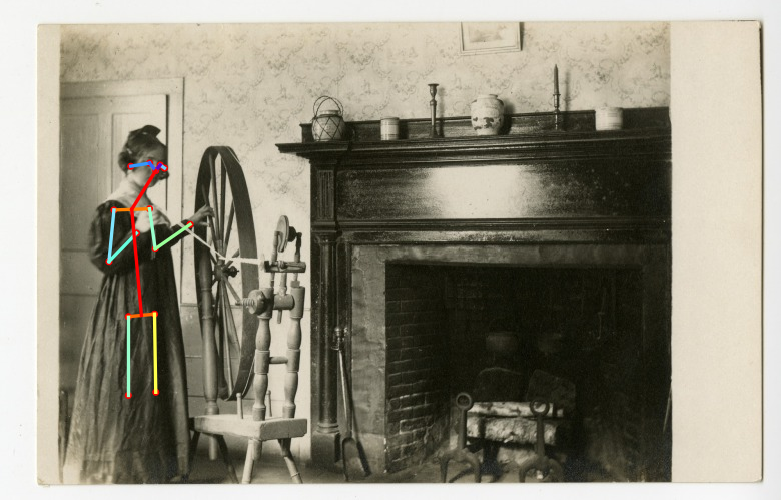

In [ ]:
out = anno.visualize_last_predictions(img)
cv2_imshow(out)

Notice that it does a good job detecting the faces and upper-bodies of the
woman, but finds her feet more difficult given her clothes.

### 3.8 Large Vocabulary Instance Segmentation

Several other annotators in the toolkit function similarly to those already
presented, but provide slightly different models and approaches. For example,
the Large Vocabulary Instance Segmentation (LVIS) algorithm detects a larger
class of more particular objects:

In [ ]:
anno = LVISAnnotator()
anno.annotate(img)['lvis']

model_final_5e3439.pkl: 456MB [00:08, 52.9MB/s]                           


index  height  width  ...          y0          x1          y1
0      0     500    781  ...  159.245331  191.194107  476.509735
1      1     500    781  ...  115.375732  675.097717  489.138947
2      2     500    781  ...   65.339699  558.369690  106.637001

[3 rows x 9 columns]

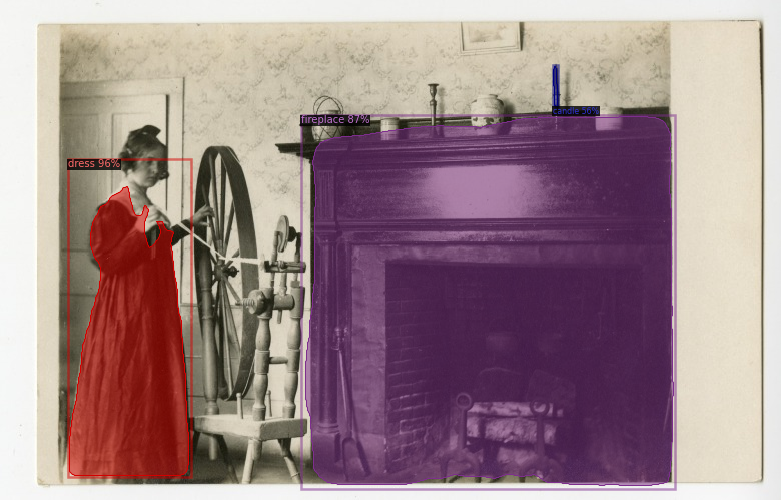

In [ ]:
out = anno.visualize_last_predictions(img)
cv2_imshow(out)

# 4. Applying to the Whole Collection

### 4.1 Compute Simple Annotator on All Images

Looking at one image is interesting, but what if we apply an annotator to the entire collection? We can do that with the code below.

In [ ]:
output = DVTOutput()
anno_avg = AverageAnnotator()

for fname in dt.filename.values:
    img_path = "postcards/images/" + fname
    img = imread(img_path)
    output.set_meta("file", img_path)
    output.add_annotation(anno_avg.annotate(img))

Here is what the averages data looks like:

In [ ]:
output.get_dataframes()["average"]

file  saturation         val
0     postcards/images/1986_3048_0642_back.jpg  116.849526  132.846958
1    postcards/images/1986_3048_0642_front.jpg   60.195289  204.397360
2     postcards/images/1986_3048_0645_back.jpg   69.289489  192.706136
3    postcards/images/1986_3048_0645_front.jpg   53.119193  218.271172
4     postcards/images/1986_3048_0647_back.jpg   60.211635  132.800421
..                                         ...         ...         ...
524     postcards/images/PG_78_38_35_front.jpg   62.148464  218.559580
525      postcards/images/PG_78_38_36_back.jpg   86.326689  166.266425
526     postcards/images/PG_78_38_36_front.jpg   69.283529  219.533827
527      postcards/images/PG_78_38_37_back.jpg   78.178057  161.331017
528     postcards/images/PG_78_38_37_front.jpg   56.951503  211.550159

[529 rows x 3 columns]

### 4.2 Nearest Embedding

We can also apply the embedding annotator, which will enable finding nearest neighbors. Note that it will take a few minutes to finish.

In [ ]:
output = DVTOutput()
anno = EmbedAnnotator(embedding=EmbedImageKerasResNet50())

for fname in dt.filename.values:
    img_path = "postcards/images/" + fname
    img = imread(img_path)
    output.set_meta("file", img_path)
    output.add_annotation(anno.annotate(img))

X = np.vstack(output.get_dataframes()["embed"].embed)

Now, we can compute the images that are the closest to any starting image.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = (16, 16)

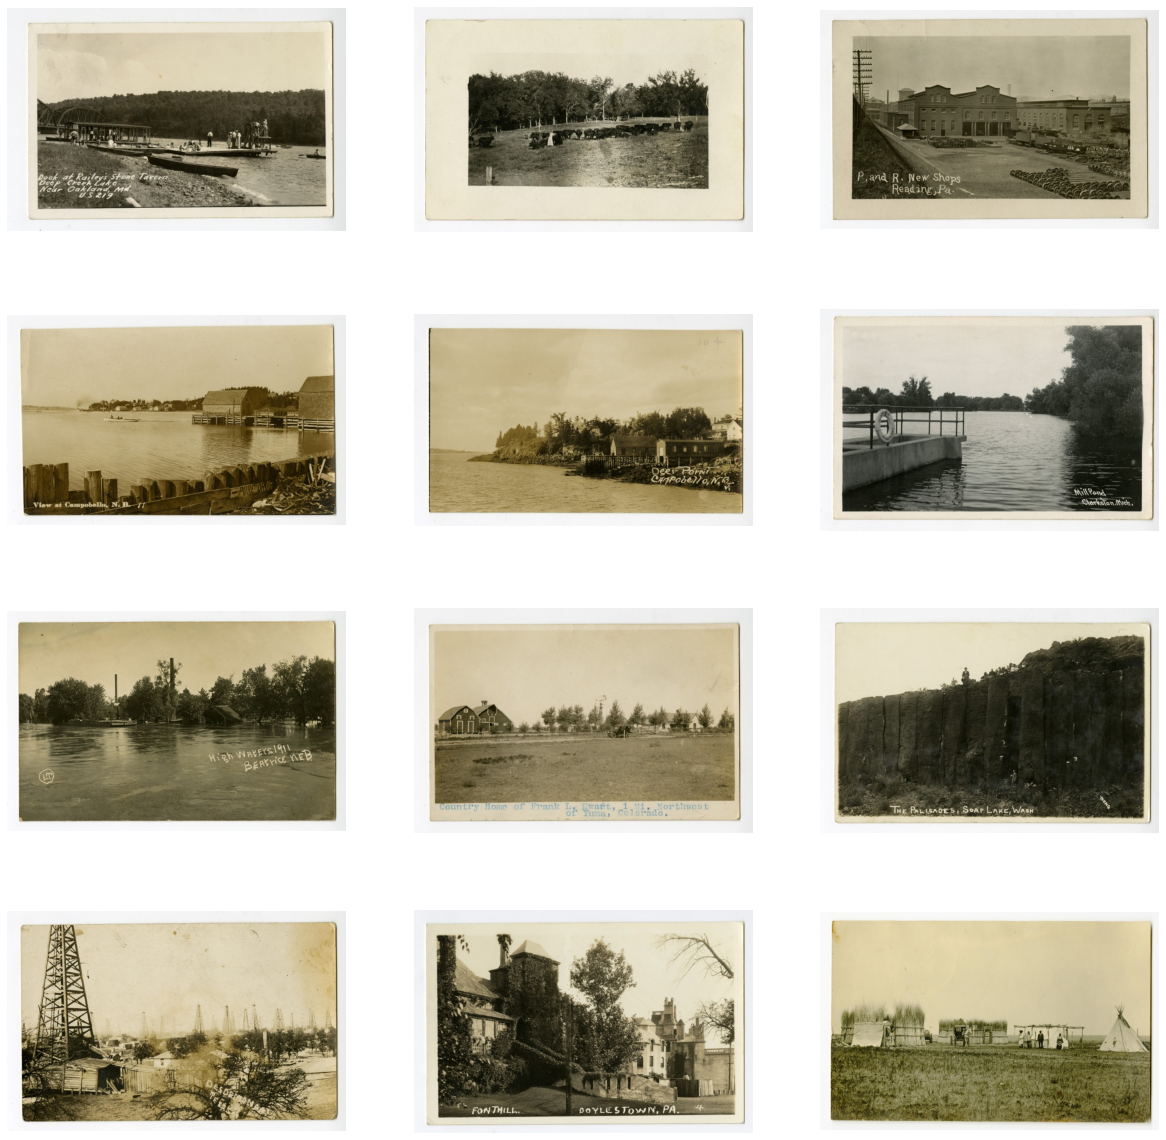

In [ ]:
ref_img_num = 20       # change this number!

idx = np.argsort(np.sum(np.abs(X - X[ref_img_num, :])**2, axis=1))[:12]
for ind, i in enumerate(idx):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(4, 3, ind + 1)

    img_bgr = imread("postcards/images/" + dt.filename[i])
    im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis("off")

## 5. Select Your Image!


Now, let's look at the images that you want to see!

In [ ]:
dt[dt.id == "2018.0166.0047"]

filename  height  width              id   type
415   2018_0166_0047_back.jpg    1297   2000  2018.0166.0047   back
416  2018_0166_0047_front.jpg    1297   2000  2018.0166.0047  front

## **6**. Conclusions and Cautions

Applying computer vision algorithms to large collections of culturally important images and moving images offers some exciting possibilities. The
Distant Viewing Toolkit was designed to lower the barrier of doing this and
make the possibilities more accessible to a wide range of interested users.
However, there remain many technical and ethical challenges for the application
of this work that should not be ignored. We encourage you to explore the
toolkit, while being aware of the potential issues and unintended consequences
that these methods could exacerbate.

If you are interested in discuss these issues and areas of application, please
reach out the Distant Viewing Lab's directors Taylor Arnold
(tarnold2@richmond.edu) and Lauren Tilton (ltilton@richmond.edu).

We see here that it is able to detect a braclet and a ring in the image.